In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cure-bench/curebench_valset_pharse1.jsonl
/kaggle/input/cure-bench/curebench_testset_phase1.jsonl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:


file_path = "/kaggle/input/cure-bench/curebench_testset_phase1.jsonl"


df = pd.read_json(file_path, lines=True)


print(df.head())


             id            question_type  \
0  qHBAJ2T5cs5U  open_ended_multi_choice   
1  dYtEF1FnUwSQ  open_ended_multi_choice   
2  IKWfGHlG9aaL  open_ended_multi_choice   
3  XCM1462WATI2  open_ended_multi_choice   
4  tvnSoQOIv0R0             multi_choice   

                                            question  \
0  A 10-year-old child diagnosed with juvenile rh...   
1  A 70-year-old male with familial chylomicronem...   
2  Which thyroid hormone replacement therapy is c...   
3  Which over-the-counter supplement should be av...   
4  What was the purpose of the 6-month study cond...   

                                             options  
0  {'A': 'Celecoxib 200 mg', 'B': 'First Aid Dire...  
1  {'A': 'TRYNGOLZA (Olezarsen Sodium) without do...  
2  {'A': 'Doxorubicin Hydrochloride', 'B': 'NP Th...  
3  {'A': 'Vitamin D', 'B': 'St. John's Wort', 'C'...  
4  {'A': 'To study the effects of REMICADE on car...  


In [4]:
df.shape

(2079, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2079 non-null   object
 1   question_type  2079 non-null   object
 2   question       2079 non-null   object
 3   options        2079 non-null   object
dtypes: object(4)
memory usage: 65.1+ KB


In [6]:
print(df["options"].iloc[0])   


{'A': 'Celecoxib 200 mg', 'B': 'First Aid Direct Chewable Aspirin', 'C': 'Florexa', 'D': 'None of the above'}


In [7]:
print(df.isnull().sum())

id               0
question_type    0
question         0
options          0
dtype: int64


In [8]:
print(df["question_type"].value_counts())

question_type
open_ended_multi_choice    1274
multi_choice                663
open_ended                  142
Name: count, dtype: int64


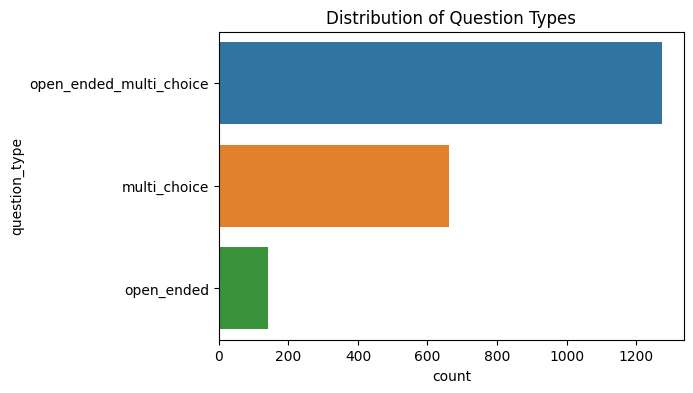

In [9]:
# ========================
plt.figure(figsize=(6,4))
sns.countplot(y=df["question_type"])
plt.title("Distribution of Question Types")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


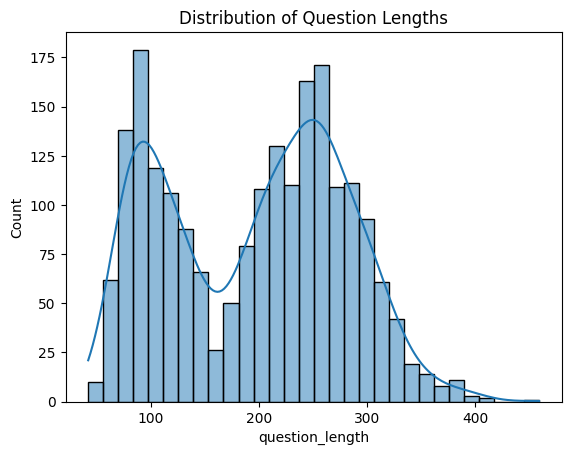

In [10]:
df["question_length"] = df["question"].apply(lambda x: len(str(x)))
sns.histplot(df["question_length"], bins=30, kde=True)
plt.title("Distribution of Question Lengths")
plt.show()

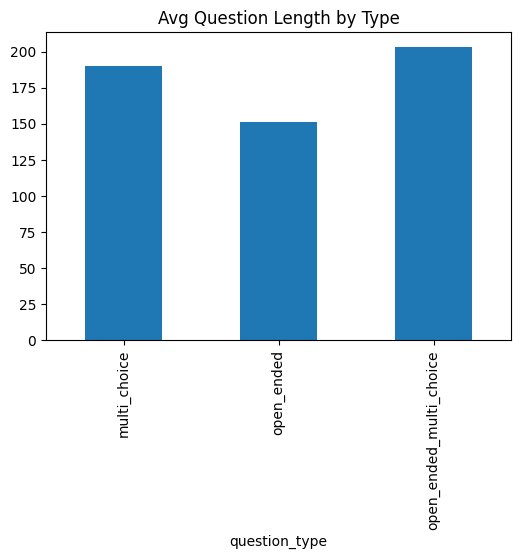

In [11]:
df.groupby("question_type")["question_length"].mean().plot(kind="bar", figsize=(6,4))
plt.title("Avg Question Length by Type")
plt.show()

In [12]:
options_df = df["options"].apply(pd.Series)
df_expanded = pd.concat([df.drop(columns=["options"]), options_df], axis=1)
print(df_expanded.head())

             id            question_type  \
0  qHBAJ2T5cs5U  open_ended_multi_choice   
1  dYtEF1FnUwSQ  open_ended_multi_choice   
2  IKWfGHlG9aaL  open_ended_multi_choice   
3  XCM1462WATI2  open_ended_multi_choice   
4  tvnSoQOIv0R0             multi_choice   

                                            question  question_length  \
0  A 10-year-old child diagnosed with juvenile rh...              207   
1  A 70-year-old male with familial chylomicronem...              276   
2  Which thyroid hormone replacement therapy is c...              201   
3  Which over-the-counter supplement should be av...              107   
4  What was the purpose of the 6-month study cond...              127   

                                                   A  \
0                                   Celecoxib 200 mg   
1  TRYNGOLZA (Olezarsen Sodium) without dose adju...   
2                          Doxorubicin Hydrochloride   
3                                          Vitamin D   
4  To study the 

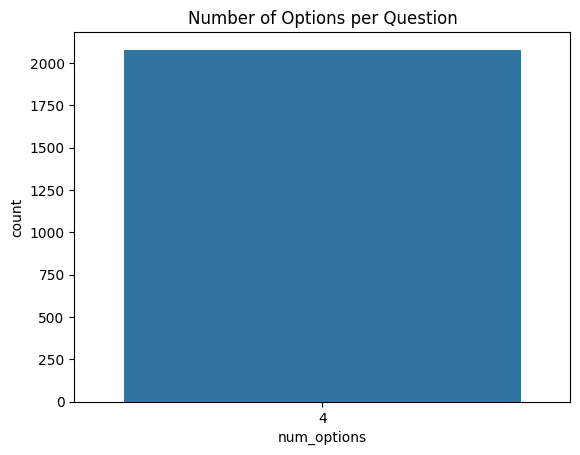

In [13]:
df["num_options"] = df["options"].apply(lambda x: len(x) if isinstance(x, dict) else 0)
sns.countplot(x=df["num_options"])
plt.title("Number of Options per Question")
plt.show()

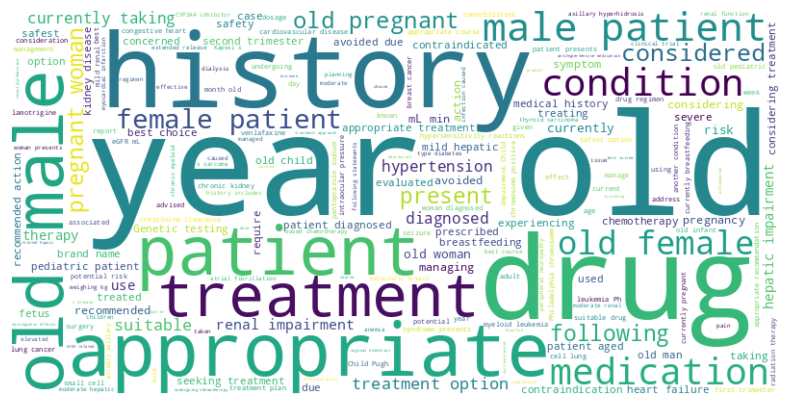

In [14]:
text = " ".join(df["question"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
le = LabelEncoder()
df["question_type_encoded"] = le.fit_transform(df["question_type"])
print(le.classes_)

['multi_choice' 'open_ended' 'open_ended_multi_choice']


In [16]:
X = df["question"]
y = df["question_type_encoded"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [19]:
model = LogisticRegression(max_iter=200, random_state=42)

In [20]:
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [21]:
y_pred = model.predict(X_test_tfidf)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8701923076923077


In [23]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

                         precision    recall  f1-score   support

           multi_choice       0.89      0.89      0.89       133
             open_ended       0.00      0.00      0.00        28
open_ended_multi_choice       0.86      0.95      0.91       255

               accuracy                           0.87       416
              macro avg       0.58      0.62      0.60       416
           weighted avg       0.81      0.87      0.84       416



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


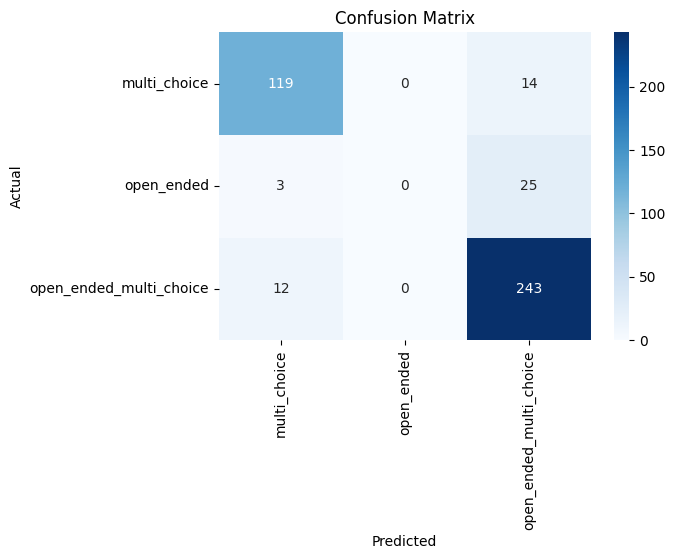

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]
top_features = np.argsort(coefs)[-10:]
print("Top 10 important words:", feature_names[top_features])


Top 10 important words: ['withdrawal' 'history' 'heart' 'uln' '15' 'takhzyro' 'condition'
 'alcohol' 'drugs' 'following']


In [26]:
df.to_csv("processed_curebench.csv", index=False)


In [27]:
import joblib
joblib.dump(model, "logistic_model.pkl")

['logistic_model.pkl']

In [28]:
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [29]:
print("✅ EDA, Visualization, Preprocessing & Model Training Done Successfully!")

✅ EDA, Visualization, Preprocessing & Model Training Done Successfully!
